In [1]:
seed = 42

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import re

C:\Users\vardh\AppData\Roaming\Python\Python310\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from datasets import load_dataset

dataset = load_dataset("keivalya/MedQuad-MedicalQnADataset")

In [4]:
train = dataset['train']
train_df = pd.DataFrame(train)

In [5]:
display(train_df.head())
train_df.shape

,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


(16407, 3)

In [6]:
labels_to_remove = ['support groups', 'complications', 'stages']
df_train = train_df[~train_df['qtype'].isin(labels_to_remove)]

In [7]:
df_train.shape

(16283, 3)

In [8]:
from transformers import BertTokenizer, BertModel

In [9]:
# Use ClinicalBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')
model = BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

In [10]:
def form_X_array_in_batches(tokenizer, model, texts, batch_size):
    X_array = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, max_length=512, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():  # Ensure no gradients are calculated
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
        X_array.append(embeddings.cpu())  # Move embeddings to CPU to save GPU memory
    X_array = torch.cat(X_array, dim=0)
    return X_array

In [11]:
batch_size = 8  # Adjust batch size based on your system's memory
print('\n Extracting Train Embeddings')
train_embeddings = form_X_array_in_batches(tokenizer, model, df_train['Question'].tolist(), batch_size)


 Extracting Train Embeddings


In [12]:
train_embeddings.shape

torch.Size([16283, 768])

In [13]:
train_embeddings.numpy()

# Convert each tensor to a list
embedding_list = [train_embeddings[i].tolist() for i in range(train_embeddings.shape[0])]

# Add these lists as a new column in the DataFrame
df_train['embeddings'] = embedding_list


C:\Users\vardh\AppData\Local\Temp\ipykernel_2520\1705234562.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['embeddings'] = embedding_list


In [14]:
df_train.head()

,qtype,Question,Answer,embeddings
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...,"[0.24930141866207123, 0.036466069519519806, -0..."
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...,"[0.13750021159648895, -0.0017314216820523143, ..."
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...,"[0.24930141866207123, 0.036466069519519806, -0..."
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos...","[0.34114545583724976, -0.02490196004509926, -0..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen...","[0.14023013412952423, 0.052422285079956055, -0..."


In [15]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

In [16]:
# Fit and transform the labels
df_train['labels'] = label_encoder.fit_transform(df_train['qtype'])

C:\Users\vardh\AppData\Local\Temp\ipykernel_2520\2147678393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['labels'] = label_encoder.fit_transform(df_train['qtype'])


In [17]:
# Create a mapping of the original labels to the encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Label Encoding Mapping:")
for original_label, encoded_label in label_mapping.items():
    print(f"{original_label}: {encoded_label}")

Label Encoding Mapping:
causes: 0
considerations: 1
exams and tests: 2
frequency: 3
genetic changes: 4
information: 5
inheritance: 6
outlook: 7
prevention: 8
research: 9
susceptibility: 10
symptoms: 11
treatment: 12


In [18]:
display(df_train)
df_train.shape

,qtype,Question,Answer,embeddings,labels
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...,"[0.24930141866207123, 0.036466069519519806, -0...",10
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...,"[0.13750021159648895, -0.0017314216820523143, ...",11
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...,"[0.24930141866207123, 0.036466069519519806, -0...",10
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos...","[0.34114545583724976, -0.02490196004509926, -0...",2
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen...","[0.14023013412952423, 0.052422285079956055, -0...",12
...,...,...,...,...,...
16402,symptoms,What are the symptoms of Familial visceral myo...,What are the signs and symptoms of Familial vi...,"[0.1360057294368744, 0.1457340270280838, -0.17...",11
16403,information,What is (are) Pseudopelade of Brocq ?,Pseudopelade of Brocq (PBB) is a slowly progre...,"[0.23785822093486786, 0.10214877873659134, -0....",5
16404,symptoms,What are the symptoms of Pseudopelade of Brocq ?,What are the signs and symptoms of Pseudopelad...,"[0.15715822577476501, -0.02364027127623558, -0...",11
16405,treatment,What are the treatments for Pseudopelade of Br...,Is there treatment or a cure for pseudopelade ...,"[0.14804881811141968, 0.04639827832579613, -0....",12


(16283, 5)

In [19]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df_train ,test_size = 0.3, random_state = seed)

In [20]:
display(train_df.shape)
display(train_df.head())

(11398, 5)

,qtype,Question,Answer,embeddings,labels
5025,information,Do you have information about Vasectomy,Summary : Vasectomy is a type of surgery that ...,"[0.12877517938613892, 0.2642013430595398, -0.5...",5
5807,treatment,What are the treatments for KBG syndrome ?,These resources address the diagnosis or manag...,"[0.23773929476737976, 0.07688256353139877, -0....",12
3187,treatment,What are the treatments for Hairy Cell Leukemia ?,Key Points\n - There are di...,"[0.12197723239660263, 0.04673199728131294, -0....",12
13884,symptoms,What are the symptoms of Infantile spasms broa...,What are the signs and symptoms of Infantile s...,"[0.08833817392587662, 0.22311824560165405, -0....",11
3917,treatment,What are the treatments for Parkinson's Disease ?,"Deep Brain Stimulation Deep brain stimulation,...","[0.06684915721416473, 0.11093048751354218, -0....",12


In [21]:
display(test_df.shape)
display(test_df.head())

(4885, 5)

,qtype,Question,Answer,embeddings,labels
12083,symptoms,What are the symptoms of Harrod Doman Keele sy...,What are the signs and symptoms of Harrod Doma...,"[0.18203911185264587, -0.11789435148239136, -0...",11
15285,symptoms,What are the symptoms of Preaxial polydactyly ...,What are the signs and symptoms of Preaxial po...,"[0.13639184832572937, 0.17144176363945007, -0....",11
1662,causes,What causes What I need to know about Hirschsp...,"Before birth, a childs nerve cells normally gr...","[0.4694878160953522, -0.17726312577724457, -0....",0
11238,symptoms,What are the symptoms of Achondrogenesis ?,What are the signs and symptoms of Achondrogen...,"[0.19248098134994507, -0.04432280361652374, -0...",11
13787,symptoms,What are the symptoms of Trigger thumb ?,What are the signs and symptoms of Trigger thu...,"[0.13349485397338867, 0.13798664510250092, -0....",11


In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [23]:
X = np.array(train_df['embeddings'].to_list())
y = train_df['labels']

display(X.shape)

display(y.shape)

(11398, 768)

(11398,)

In [24]:
x_train, x_val, y_train, y_val = train_test_split(X, y ,test_size = 0.3, random_state = seed)

In [25]:
display(x_train.shape)
display(x_val.shape)
display(y_train.shape)
display(y_val.shape)

(7978, 768)

(3420, 768)

(7978,)

(3420,)

In [27]:
model_ann = Sequential([
    Dense(512, input_shape = (768,), activation = 'relu'),
    Dropout(0.2),
    Dense(256, activation = 'relu'),
    Dropout(0.3),
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(13, activation = 'softmax')
])
model_ann.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 512)               393728    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [28]:
model_ann.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [29]:
history = model_ann.fit(
    x_train, y_train,
    epochs = 10,
    batch_size = 8,
    validation_data = (x_val,y_val)
)

Epoch 1/10
998/998 [==============================] - 6s 5ms/step - loss: 0.5341 - accuracy: 0.8287 - val_loss: 0.0303 - val_accuracy: 0.9868
Epoch 2/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0900 - accuracy: 0.9728 - val_loss: 0.0664 - val_accuracy: 0.9845
Epoch 3/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0484 - accuracy: 0.9865 - val_loss: 0.0092 - val_accuracy: 0.9982
Epoch 4/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0367 - accuracy: 0.9915 - val_loss: 0.0105 - val_accuracy: 0.9971
Epoch 5/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0319 - accuracy: 0.9921 - val_loss: 0.0094 - val_accuracy: 0.9980
Epoch 6/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0267 - accuracy: 0.9927 - val_loss: 0.0075 - val_accuracy: 0.9982
Epoch 7/10
998/998 [==============================] - 5s 5ms/step - loss: 0.0509 - accuracy: 0.9883 - val_loss: 0.0039 - val_accuracy: 0.9988
Epoch 

In [30]:
loss, accuracy = model_ann.evaluate(X, y)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

357/357 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 0.9985
Validation Accuracy: 99.85%


In [31]:
predictions = model_ann.predict(np.array(test_df['embeddings'].tolist()))

153/153 [==============================] - 0s 934us/step


In [32]:
# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

# Calculate evaluation metrics
accuracy = accuracy_score(test_df['labels'], predicted_labels)
f1 = f1_score(test_df['labels'], predicted_labels, average = 'weighted')  # Use weighted average for multi-class
precision = precision_score(test_df['labels'], predicted_labels, average='weighted')
recall = recall_score(test_df['labels'], predicted_labels, average='weighted')

In [34]:
# Print the evaluation metrics
print(f'Test Accuracy: {accuracy * 100:.2f}%')
print(f'Weighted F1 Score: {f1:.2f}')
print(f'Weighted Precision: {precision:.2f}')
print(f'Weighted Recall: {recall:.2f}')


Test Accuracy: 99.82%
Weighted F1 Score: 1.00
Weighted Precision: 1.00
Weighted Recall: 1.00


<Figure size 3000x3000 with 0 Axes>

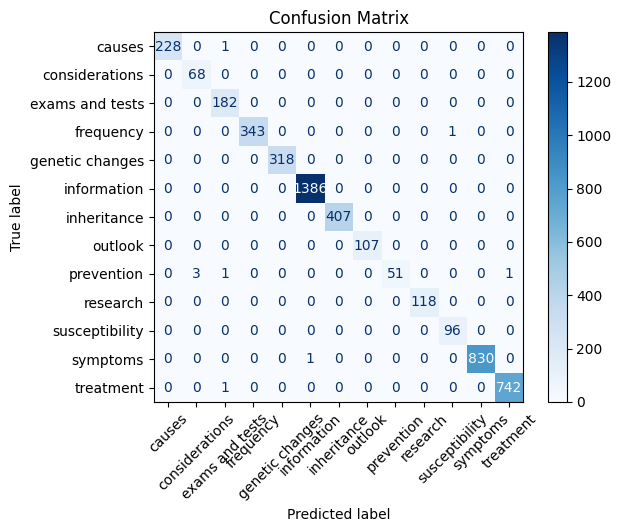

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculate the confusion matrix
cm = confusion_matrix(test_df['labels'], predicted_labels)

# Create a larger figure for better readability
plt.figure(figsize=(30,30))

# Display the confusion matrix with tilted x-tick labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)

plt.title('Confusion Matrix')
plt.show()